# Elena's EDA notebook

# todo list
- filter out ûï@mention and http url links and \x89

In [2]:
import pandas as pd
import numpy as np
import random

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

import re
from nltk import pos_tag
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer 

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(context = 'notebook', style = 'whitegrid')
ppt_colors = ['#4285f4', '#4e8df5', '#5b95f5', '#5b95f5', '#5b95f5', '#81aef7', '#81aef7', '#81aef7', '#81aef7', '#c3d8fb']

In [3]:
df = pd.read_csv('../../data/judge-1377884607_tweet_product_company.csv', encoding = 'latin1')
df.columns = ['text', 'target', 'emotion']

df = df[df['emotion'] != 'I can\'t tell']
df['target'].replace(['iPad', 'iPad or iPhone App', 'iPhone', 'Other Apple product or service'], 'Apple', inplace = True)
df['target'].replace(['Other Google product or service'], 'Google', inplace = True)
df['target'].replace(['Android App'], 'Android', inplace = True)

df['target'].fillna('No Target', inplace = True)
df.dropna(inplace = True)

In [6]:
df['target'].value_counts()

Apple      2402
Google      721
Android     159
Name: target, dtype: int64

In [5]:
df.drop(df.loc[df['target']=='No Target'].index, inplace=True)
df

,text,target,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Apple,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9077,@mention your PR guy just convinced me to swit...,Apple,Positive emotion
9079,&quot;papyrus...sort of like the ipad&quot; - ...,Apple,Positive emotion
9080,Diller says Google TV &quot;might be run over ...,Google,Negative emotion
9085,I've always used Camera+ for my iPhone b/c it ...,Apple,Positive emotion


# Initial EDA

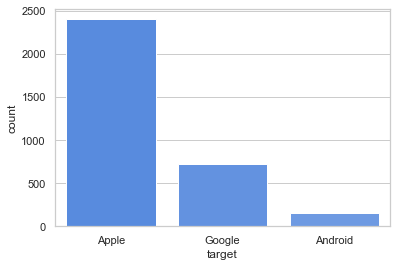

In [7]:
# target breakdown

sns.set(context = 'notebook', style = 'whitegrid', font_scale = 1)

ax = sns.countplot(x = 'target', data = df, palette = ppt_colors)

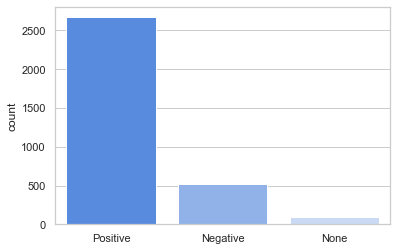

In [8]:
# emotion breakdown

sns.set(context = 'notebook', style = 'whitegrid', font_scale = 1)

ax = sns.countplot(x = 'emotion', data = df, palette = [ppt_colors[0], ppt_colors[5], ppt_colors[-1]], order = ['Positive emotion', 'Negative emotion', 'No emotion toward brand or product'])
ax.set(xlabel = '', xticklabels = ['Positive', 'Negative', 'None'])
plt.show()

In [9]:
# emotion breakdown by target

df.groupby(['target', 'emotion']).count()

text
target  emotion                                 
Android Negative emotion                      16
        No emotion toward brand or product     2
        Positive emotion                     141
Apple   Negative emotion                     388
        No emotion toward brand or product    65
        Positive emotion                    1949
Google  Negative emotion                     115
        No emotion toward brand or product    24
        Positive emotion                     582

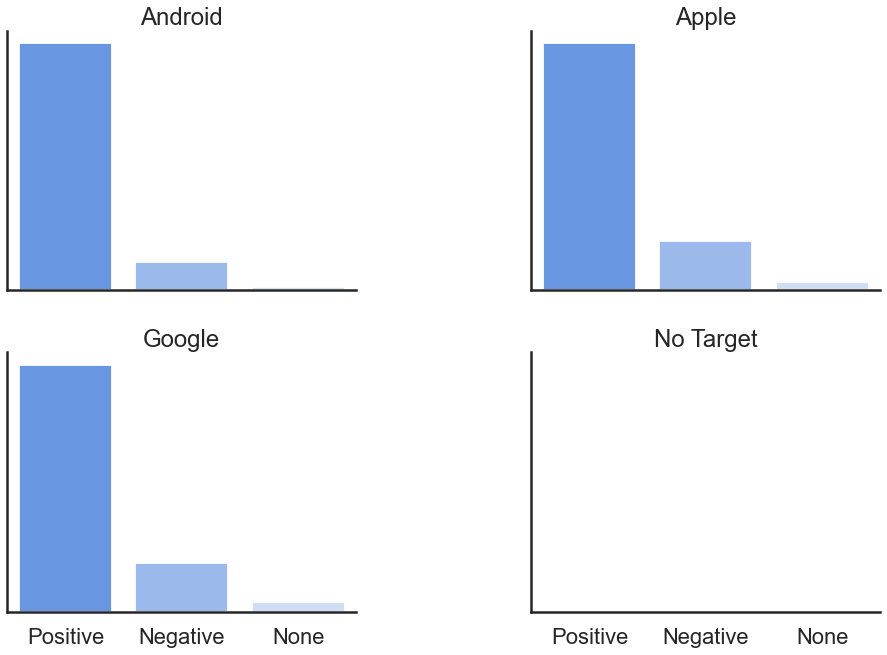

In [10]:
# emotion breakdown by target but fancier

sns.set(context = 'poster', style = 'white', font_scale = 1)
xlabel = ''
ylabel = ''
xticks = ['Positive', 'Negative', 'None']
yticks = ''
order = ['Positive emotion', 'Negative emotion', 'No emotion toward brand or product']
col_order = ['Android','Apple', 'Google', 'No Target']

ax = sns.catplot(data = df, x = 'emotion', col = 'target', kind = 'count', palette = [ppt_colors[0], ppt_colors[5], ppt_colors[-1]], order = order, col_order = col_order, col_wrap = 2, sharey = False, height = 5, aspect = 1.5, alpha = 0.9)
ax.set(xlabel = xlabel, ylabel = ylabel, xticklabels = xticks, yticklabels = yticks, title = 'Tweet Emotion per Target')
ax.despine(left = False)
ax.set_titles('{col_name}')
plt.savefig('../../reports/figures/emotion_target_breakdown_base.png', dpi = 500, bbox_inches = 'tight', transparent = True)
plt.show()

# Text Cleaning

In [11]:
sw = stopwords.words('english')
sw.extend(['link', 'rt', 'sxsw', 'get', 'google', 'apple', 'iphone', 'ipad'])
punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~“!'
twitter_re = re.compile('[#@][a-zA-Z]*')
num_re = re.compile('^\d{1}$')

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def txt_clean(txt, stop_words=sw):
    # takes in a string and returns a cleaned up string ready for count or tfidf vectorizing
    
    # splitting the text up into words
    t = txt.split(' ')
    # turning the words lowercase
    t = [w.lower() for w in t]
    # removing punctuation
    t = [w.translate(w.maketrans('','', punctuation)) for w in t]
    # removing @'s and #'s which are twitter jargon
    t = [w for w in t if not twitter_re.match(w)]
    # removing leftover numbers
    t = [w for w in t if not num_re.match(w)]
    # removing stop words and more twitter jargon
    t = [w for w in t if w not in stop_words]
    # removing empty strings
    t = [w for w in t if w]
    # word lemmatizing
    t = pos_tag(t)
    t = [(w[0], get_wordnet_pos(w[1])) for w in t]
    lem = WordNetLemmatizer()
    t = [lem.lemmatize(w[0], w[1]) for w in t]
    # joining all the strings together into one
    return ' '.join(t)

df['txt_cleaned'] = df['text'].map(txt_clean)

# Data Preprocessing 

In [12]:
# divides data into X and y, and then turns the model target labels into numerical format

X = df['txt_cleaned']
y = df['emotion'].replace(to_replace = {'Negative emotion' : 0, 'No emotion toward brand or product' : 1, 'Positive emotion': 2})

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.25)
X_t, X_val, y_t, y_val = train_test_split(X, y, random_state = 42, test_size = 0.25)

In [13]:
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,\
RandomForestClassifier, BaggingClassifier, ExtraTreesRegressor, VotingRegressor
from sklearn.tree import DecisionTreeClassifier

# Transformers
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Modeling Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, auc, recall_score, f1_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
classification_report, accuracy_score

# Pipelines
from imblearn.pipeline import Pipeline, make_pipeline

# SMOTE
from imblearn.over_sampling import SMOTE

In [66]:
X_t_vec_np = X_t_vec.to_numpy()
y_t_np = y_t.to_numpy()

In [67]:
X_val_vec_np = X_val_vec.to_numpy()
y_val_np = y_val.to_numpy()

In [49]:
X_t_np = X_t.to_numpy()
y_t_np = y_t.to_numpy()

# Multinomial Naive Bayes

In [14]:
X_t

8363    hate fleet nerd arm ipads navigate crowd far c...
7689             even security guard austin enjoy time cc
7047    many product isnt time transition chain featur...
7780    cool update npr music app song info song 247 a...
5786           go new guide free march 915 hard beat free
                              ...                        
2851    need best android dev html5js issue need solve...
2946    ha guy talk explain make realistic twitter bot...
3389    lunch view html5 dev trench android painful io...
2245                                      web fontspretty
8794                      photo save style take instagram
Name: txt_cleaned, Length: 2461, dtype: object

In [41]:
#pipeline_nb = make_pipeline(SMOTE(), MultinomialNB())
#pipeline_nb

Pipeline(steps=[('smote', SMOTE()), ('multinomialnb', MultinomialNB())])

### TF-IDF Vectorizer

In [15]:
pipeline_nb_tf = make_pipeline(TfidfVectorizer(), SMOTE(), MultinomialNB())
pipeline_nb_tf

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()), ('smote', SMOTE()),
                ('multinomialnb', MultinomialNB())])

In [16]:
# Parameters of pipelines can be set using ‘__’ separated parameter names:
# Define the parameter grid
grid_nb_tf = {
    'tfidfvectorizer__min_df': [1, 2],
    'tfidfvectorizer__max_df': [0.01, 0.05, 0.25],
    'tfidfvectorizer__ngram_range': [(1,1), (1,2), (2,2), (2,3), (3,3)],
    'tfidfvectorizer__norm': ('l1', 'l2'),
    'multinomialnb__alpha': [1, 0.1, 0.01, 0.001]   
}

In [17]:
gs_nb_tf = GridSearchCV(pipeline_nb_tf, grid_nb_tf, cv=3)

In [18]:
gs_nb_tf.fit(X_t, y_t)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('smote', SMOTE()),
                                       ('multinomialnb', MultinomialNB())]),
             param_grid={'multinomialnb__alpha': [1, 0.1, 0.01, 0.001],
                         'tfidfvectorizer__max_df': [0.01, 0.05, 0.25],
                         'tfidfvectorizer__min_df': [1, 2],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (2, 2), (2, 3),
                                                          (3, 3)],
                         'tfidfvectorizer__norm': ('l1', 'l2')})

In [19]:
gs_nb_tf.best_params_

{'multinomialnb__alpha': 0.001,
 'tfidfvectorizer__max_df': 0.05,
 'tfidfvectorizer__min_df': 1,
 'tfidfvectorizer__ngram_range': (1, 2),
 'tfidfvectorizer__norm': 'l2'}

In [20]:
gs_nb_tf.best_estimator_

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.05, ngram_range=(1, 2))),
                ('smote', SMOTE()),
                ('multinomialnb', MultinomialNB(alpha=0.001))])

In [27]:
gs_nb_tf.fit(X_val, y_val)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('smote', SMOTE()),
                                       ('multinomialnb', MultinomialNB())]),
             param_grid={'multinomialnb__alpha': [1, 0.1, 0.01, 0.001],
                         'tfidfvectorizer__max_df': [0.01, 0.05, 0.25],
                         'tfidfvectorizer__min_df': [1, 2],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (2, 2), (2, 3),
                                                          (3, 3)],
                         'tfidfvectorizer__norm': ('l1', 'l2')})

In [28]:
y_pred_nb_tf_train = gs_nb_tf.predict(X_val)
accuracy_score(y_val, y_pred_nb_tf_train)

0.9902557856272838

In [29]:
y_pred_nb_tf = gs_nb_tf.predict(X_val)
accuracy_score(y_val, y_pred_nb_tf)

0.9902557856272838

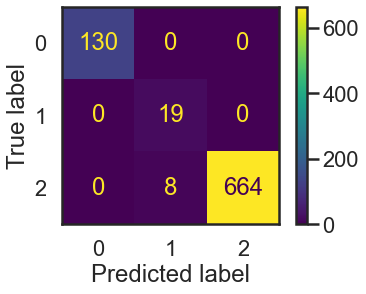

In [30]:
plot_confusion_matrix(gs_nb_tf, X_val, y_val)

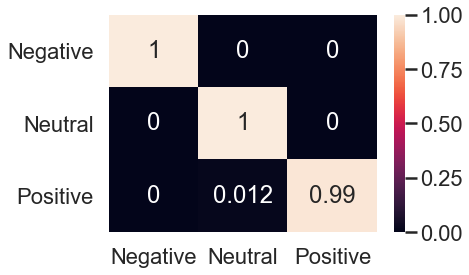

In [31]:
plot_confusion_matrix1(y_val,y_pred_nb_tf)

In [32]:
gs_nb_tf.best_score_

0.8002370703100631

In [33]:
gs_nb_tf.best_estimator_.score(X_val, y_val)

0.9902557856272838

In [34]:
gs_nb_tf.cv_results_

{'mean_fit_time': array([0.01727398, 0.01673603, 0.02374951, 0.02086719, 0.01691063,
        0.0159483 , 0.02280211, 0.02240165, 0.01559567, 0.01533802,
        0.01157832, 0.01152563, 0.01629551, 0.01612798, 0.01349394,
        0.0134747 , 0.01706211, 0.01703119, 0.01265804, 0.01282644,
        0.01294017, 0.01312272, 0.02093498, 0.02029395, 0.01655364,
        0.01663804, 0.03023903, 0.02785699, 0.01788433, 0.01585428,
        0.012019  , 0.01300367, 0.01730402, 0.01795808, 0.01578442,
        0.01482399, 0.01755746, 0.01838398, 0.01294939, 0.01339173,
        0.01383034, 0.01335263, 0.02237892, 0.02207764, 0.01758107,
        0.01741552, 0.02476724, 0.02425265, 0.01807793, 0.01820024,
        0.01403999, 0.01360631, 0.01780534, 0.01698518, 0.0133156 ,
        0.01340469, 0.01733033, 0.0172267 , 0.01296306, 0.01299135,
        0.01258111, 0.0124406 , 0.02053642, 0.02018126, 0.01645525,
        0.01610827, 0.02286482, 0.02220805, 0.01597039, 0.01562794,
        0.01183637, 0.011976  ,

### Count Vectorizer

In [35]:
pipeline_nb_cv = make_pipeline(CountVectorizer(), SMOTE(), MultinomialNB())
pipeline_nb_cv

Pipeline(steps=[('countvectorizer', CountVectorizer()), ('smote', SMOTE()),
                ('multinomialnb', MultinomialNB())])

In [36]:
# Parameters of pipelines can be set using ‘__’ separated parameter names:
# Define the parameter grid
grid_nb_cv = {
    'countvectorizer__min_df': [1, 2],
    'countvectorizer__max_df': [0.1, 0.25],
    'countvectorizer__ngram_range': [(1,1), (1,2), (2,2), (2,3), (3,3)],
    'multinomialnb__alpha': [1, 0.1, 0.01]   
}

In [37]:
# Initialize the gridsearch object with three-fold cross-validation
gs_nb_cv = GridSearchCV(pipeline_nb_cv, grid_nb_cv, cv=3)

In [38]:
gs_nb_cv.fit(X_t, y_t)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('smote', SMOTE()),
                                       ('multinomialnb', MultinomialNB())]),
             param_grid={'countvectorizer__max_df': [0.1, 0.25],
                         'countvectorizer__min_df': [1, 2],
                         'countvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (2, 2), (2, 3),
                                                          (3, 3)],
                         'multinomialnb__alpha': [1, 0.1, 0.01]})

In [39]:
gs_nb_cv.best_params_

{'countvectorizer__max_df': 0.1,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 2),
 'multinomialnb__alpha': 1}

In [40]:
gs_nb_cv.best_estimator_

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_df=0.1, ngram_range=(1, 2))),
                ('smote', SMOTE()), ('multinomialnb', MultinomialNB(alpha=1))])

In [41]:
y_pred_nb_cv = gs_nb_cv.predict(X_val)
accuracy_score(y_val, y_pred_nb_cv)

0.8501827040194885

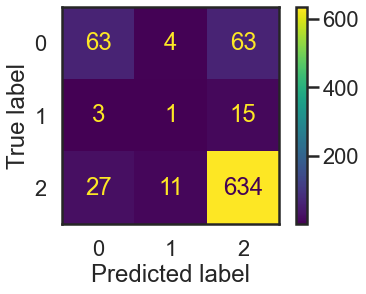

In [42]:
plot_confusion_matrix(gs_nb_cv, X_val, y_val)

In [43]:
gs_nb_cv.best_score_

0.8082122733529405

In [44]:
gs_nb_cv.best_estimator_.score(X_val, y_val)

0.8501827040194885

In [45]:
gs_nb_cv.cv_results_

{'mean_fit_time': array([0.03320026, 0.02814976, 0.02662023, 0.04790505, 0.04661163,
        0.04626624, 0.03743688, 0.03662999, 0.03590496, 0.05677183,
        0.05479169, 0.0553085 , 0.03613361, 0.03466972, 0.0346179 ,
        0.02369173, 0.02329969, 0.02326059, 0.03740112, 0.03751477,
        0.03840995, 0.02884205, 0.02816772, 0.02742076, 0.03882893,
        0.03846002, 0.0382069 , 0.027759  , 0.02633286, 0.02604167,
        0.02541741, 0.02524853, 0.0250934 , 0.04689606, 0.05904706,
        0.05313325, 0.03758804, 0.0411733 , 0.03643505, 0.05627251,
        0.05451775, 0.05577429, 0.06986578, 0.03629494, 0.0351944 ,
        0.02436535, 0.02377796, 0.02398292, 0.0382754 , 0.03790474,
        0.03829559, 0.02828693, 0.02795156, 0.02799694, 0.0395809 ,
        0.03940034, 0.03888861, 0.02897263, 0.02635145, 0.0265909 ]),
 'std_fit_time': array([3.87407998e-03, 2.14885127e-03, 1.86689453e-03, 2.19529405e-03,
        4.59977158e-04, 2.35992191e-04, 1.42838156e-03, 1.10629476e-03,
     

# FSM: Multinomial Naive Bayes

In [33]:
mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)
y_hat = mnb.predict(X_t_vec)
accuracy_score(y_t, y_hat)

0.8622511174319383

In [98]:
y_hat2 = mnb.predict(X_val_vec)
accuracy_score(y_val, y_hat)

0.8355663824604141

In [34]:
X_t_vec.sample(1).max(axis = 1)

4732    0.817702
dtype: float64

In [99]:
confusion_matrix(y_val, y_hat2)

array([[ 14,   0, 116],
       [  0,   0,  19],
       [  0,   0, 672]])

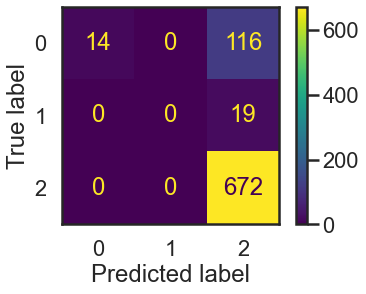

In [100]:
plot_confusion_matrix(mnb, X_val_vec, y_val)

In [39]:
 mnb.feature_log_prob_[0, :].argsort()

array([   0, 7666, 7667, ..., 8434, 2051, 3452])

In [40]:
pos_emotion_sorted = mnb.feature_log_prob_[0, :].argsort()
neg_emotion_sorted = mnb.feature_log_prob_[1, :].argsort()
no_emotion_sorted = mnb.feature_log_prob_[2, :].argsort()

print(np.take(tfidf.get_feature_names(), pos_emotion_sorted[-10:]))
print(np.take(tfidf.get_feature_names(), neg_emotion_sorted[-10:]))
print(np.take(tfidf.get_feature_names(), no_emotion_sorted[-10:]))

['heat million sun' 'ipads back button' 'button heat million'
 'fade fast among' 'among digital delegate' 'fast among digital'
 'elegant fascist company' 'quotapple elegant fascist'
 'classy fascist company' 'fascist company americaquot']
['want nonprofitsquot yes' 'quotiava want nonprofitsquot'
 'bc deserve nothing' 'nonprofitsquot yes bc' 'yes bc deserve'
 'tablet call morning' 'circle new social' 'popup store store'
 'launch new social' 'new social network']
['temporary store downtown' 'school marketing expert'
 'network call circle' 'open temporary store' 'social network call'
 'major new social' 'launch major new' 'new social network'
 'store downtown austin' 'even begin win']


In [ ]:
['network call circle' 'major new social' 'launch major new'
 'social network call' 'temporary store downtown'
 'school marketing expert' 'open temporary store' 'new social network'
 'store downtown austin' 'even begin win']
['network call circle' 'best thing ive' 'thing ive heard'
 'classy fascist company' 'quotapple elegant fascist'
 'social network call' 'new social network' 'major new social'
 'fascist company americaquot' 'fade fast among']
['popup store austin' 'store downtown austin' 'open temporary store'
 'circle possibly today' 'call circle possibly' 'launch major new'
 'major new social' 'network call circle' 'social network call'
 'new social network']

In [ ]:
new social network          80.137694
social network call         69.935329
network call circle         65.313997
major new social            64.712864
launch major new            63.743781
call circle possibly        54.022252
circle possibly today       54.005559
open temporary store        38.100215
store downtown austin       36.312710
temporary store downtown    27.969892
popup store austin          24.687708
open popup store            24.318210
downtown austin launch      23.002409
open popup shop             21.364177
launch new social           20.361676
rumor open temporary        19.746143

In [41]:
print(np.take(tfidf.get_feature_names(), pos_emotion_sorted[:10]))
print(np.take(tfidf.get_feature_names(), neg_emotion_sorted[:10]))
print(np.take(tfidf.get_feature_names(), no_emotion_sorted[:10]))

['02 symbian window' 'party calendar put' 'party cant wait'
 'party cause party' 'party congress ave' 'party depeche mode'
 'party detail reveal' 'party djroe store' 'party dont think'
 'party fun good']
['02 symbian window' 'pop shop time' 'pop store 15' 'pop store buy'
 'pop store come' 'pop store day' 'pop store downtown' 'pop store even'
 'pop store fly' 'pop store folk']
['ûóthe right house' 'crappy would never' 'crash amp fresh'
 'crash cause lose' 'crash every 10mins' 'crash every time'
 'one form factor' 'crashy year app' 'one every people' 'one doc taking']


# Logistic Regression

In [42]:
lr = LogisticRegression(penalty='l2', C=0.1, class_weight='balanced', solver ='lbfgs')
lr.fit(X_val_vec, y_val)

LogisticRegression(C=0.1, class_weight='balanced')

In [43]:
accuracy = accuracy_score(y_val, lr.fit(X_val_vec, y_val).predict(X_val_vec))

Accuracy score: 0.8660170523751523


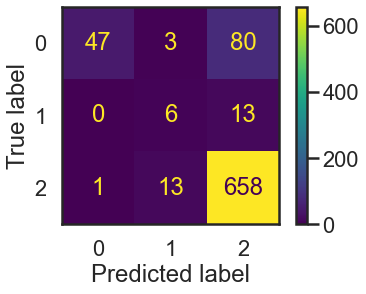

In [44]:
# score val
print('Accuracy score: {}'.format(accuracy))

# Plot confusion matrix
plot_confusion_matrix(lr, X_val_vec, y_val)

In [45]:
X_t_vec.shape

(2461, 12152)

In [48]:
smote = SMOTE()

In [49]:
X_val_vec_resampled, y_val_resampled = smote.fit_sample(X_val_vec_np, y_val_np) 

In [50]:
# Previous original class distribution
print('Original class distribution: \n')
print(y_val.value_counts())

# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_val_resampled).value_counts()) 

Original class distribution: 

2    672
0    130
1     19
Name: emotion, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

2    672
1    672
0    672
dtype: int64


In [86]:
lr_SMOTE = LogisticRegression(penalty='l2', C=1.0, solver ='lbfgs')
lr_SMOTE.fit(X_val_vec_resampled, y_val_resampled)

LogisticRegression()

In [87]:
accuracy_sm = accuracy_score(y_val_resampled, lr_SMOTE.fit(X_val_vec_resampled, y_val_resampled).predict(X_val_vec_resampled))

Accuracy score: 0.6259920634920635


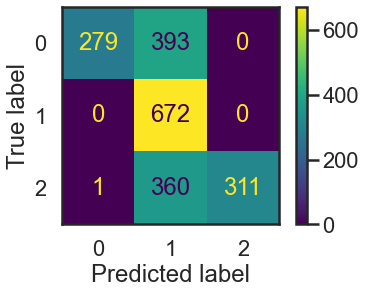

In [88]:
# score val
print('Accuracy score: {}'.format(accuracy_sm))

# Plot confusion matrix
plot_confusion_matrix(lr_SMOTE, X_val_vec_resampled, y_val_resampled)

In [89]:
lr_SMOTE.coef_[2]

array([0.        , 0.        , 0.21999435, ..., 0.        , 0.        ,
       0.        ])

In [90]:
lr_pos_emotion_sorted = lr_SMOTE.coef_[0, :].argsort()
lr_neg_emotion_sorted = lr_SMOTE.coef_[1, :].argsort()
lr_no_emotion_sorted = lr_SMOTE.coef_[2, :].argsort()

print(np.take(tfidf.get_feature_names(), lr_pos_emotion_sorted[-10:]))
print(np.take(tfidf.get_feature_names(), lr_neg_emotion_sorted[-10:]))
print(np.take(tfidf.get_feature_names(), lr_no_emotion_sorted[-10:]))

['aron pilhofer new' 'fade fast among' 'smackdown bloody banality'
 'store austin sell' 'apps fade fast' 'news apps fade' 'novelty news apps'
 'major new social' 'go buy new' 'mistake make building']
['wasnt consumer product' 'design interface new' 'new navigation schema'
 'google nerd social' 'circle loom google' 'loom google nerd'
 'circle possibly today' 'call circle possibly' 'cant wait give'
 'quotparty like 1986quot']
['google marissa mayer' 'popup store austin' 'include uberguide sponsor'
 'austin convention center' 'school marketing expert'
 'route around traffic' 'store downtown austin' 'open temporary store'
 'open popup store' 'even begin win']


In [56]:
['network call circle' 'major new social' 'launch major new'
 'social network call' 'temporary store downtown'
 'school marketing expert' 'open temporary store' 'new social network'
 'store downtown austin' 'even begin win']
['network call circle' 'best thing ive' 'thing ive heard'
 'classy fascist company' 'quotapple elegant fascist'
 'social network call' 'new social network' 'major new social'
 'fascist company americaquot' 'fade fast among']
['popup store austin' 'store downtown austin' 'open temporary store'
 'circle possibly today' 'call circle possibly' 'launch major new'
 'major new social' 'network call circle' 'social network call'
 'new social network']

['popup store austinstore downtown austinopen temporary storecircle possibly todaycall circle possiblylaunch major newmajor new socialnetwork call circlesocial network callnew social network']

In [57]:
coeffs = pd.Series(lr_SMOTE.coef_[0], index=X_val_vec.columns.values)
coeffs = coeffs.sort_values(ascending = False)
print(coeffs[:10])

novelty news apps        0.373014
news apps fade           0.373014
apps fade fast           0.373014
fade fast among          0.339479
mistake make building    0.295726
dont need 2quot          0.278486
ive heard weekend        0.268095
heard weekend quoti      0.268095
weekend quoti give       0.268095
give money relief        0.260035
dtype: float64


In [58]:
coeffs = pd.Series(lr_SMOTE.coef_[1], index=X_val_vec.columns.values)
coeffs = coeffs.sort_values(ascending = False)
print(coeffs[:10])

quotparty like 1986quot     0.823325
cant wait give              0.673563
circle loom google          0.538750
google nerd social          0.538750
loom google nerd            0.538750
design interface new        0.393417
new navigation schema       0.393417
interface new navigation    0.348416
call circle possibly        0.326496
circle possibly today       0.324462
dtype: float64


In [59]:
coeffs = pd.Series(lr_SMOTE.coef_[2], index=X_val_vec.columns.values)
coeffs = coeffs.sort_values(ascending = False)
print(coeffs[:10])

even begin win             0.473806
open popup store           0.323671
open temporary store       0.320348
store downtown austin      0.245862
quotapple come cool        0.224959
dont go conferencesquot    0.209089
one ever hear              0.206984
popup store austin         0.204840
route around traffic       0.184580
come cool technology       0.164265
dtype: float64


In [139]:
y_hat_test = lr_SMOTE.predict(X_test)

ValueError: could not convert string to float: '\x89ûï@mention doesnt place value domain extension equal'

# Dop Functions

In [25]:
def plot_confusion_matrix1(y_true,y_pred):
    import seaborn as sns

    sns.heatmap(confusion_matrix(y_true, y_pred, normalize = 'true'), 
            annot = True, 
            xticklabels = ['Negative','Neutral','Positive'],
            yticklabels = ['Negative','Neutral','Positive'])
    plt.xlabel = 'Predicted Sentiment'
    plt.ylabel = 'True Sentiment'
    plt.show()